<a href="https://colab.research.google.com/github/mohammadomarshaikh/NIDS-CIC-IDS2017-LSTM/blob/main/NIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DOWNLOADING/IMPORTING LIBRARIES REQUIRED
```



In [ ]:
# Importing the libraries

# Libraries used for the preprocessing of the data
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder, Normalizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

# Making the graphs
import matplotlib.pyplot as plt

# Data format libraries
import numpy as np
import pandas as pd

# Used for evaluation of the features extracted by ANOVA
# This is done to select the optimum number of features
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Neural Networks libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import sparse_categorical_crossentropy
import tensorflow as tf

# Used to save Normalizer and PowerTransformer
import joblib

# Metrics used for the evaluation of the models
# The accuracy score is also used but it can be seen further up where
# the libraries for ANOVA, it is used for feature extraction
from sklearn.metrics import recall_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

# Libraries used for the construction of the confusion matrix figures
# Pandas and Matplotlib are also used but they are imported further up
import seaborn as sns

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
!pip install fast_ml
# Methods used cleansing constant and quasi-constant features
from fast_ml.utilities import display_all, reduce_memory_usage
from fast_ml.feature_selection import get_constant_features

COMBINING VARIOUS FILES FROM DOWNLOADED DATASET AND CLEANING (HANDLING NAN, INFI VALUES/ STRIPPING LEADING SPACES)


In [ ]:
list_files = []

# Function to read a CSV with multiple encodings
def read_csv_with_encodings(file_path, encodings=['utf-8', 'latin1', 'ISO-8859-1']):
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, index_col=None, encoding=encoding)
            return df
        except (UnicodeDecodeError, pd.errors.ParserError):
            continue
    raise ValueError(f"Failed to read file {file_path} with given encodings.")

# List of file paths
file_paths = [
    r"Desktop/nid/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    r"Desktop/nid/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    r"Desktop/nid/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    r"Desktop/nid/Monday-WorkingHours.pcap_ISCX.csv",
    r"Desktop/nid/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    r"Desktop/nid/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    r"Desktop/nid/Tuesday-WorkingHours.pcap_ISCX.csv",
    r"Desktop/nid/Wednesday-workingHours.pcap_ISCX.csv"
]

# Reading and cleaning data
for file_path in file_paths:
    df = read_csv_with_encodings(file_path)
    df.replace([np.inf, -np.inf, "Infinity", "NaN"], np.nan, inplace=True)
    df.dropna(axis="rows", how="any", inplace=True)
    list_files.append(df)

# Concatenate all dataframes
frame = pd.concat(list_files, axis=0, ignore_index=True)

C:\Users\test2\AppData\Local\Temp\ipykernel_6344\1475877635.py:7: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, index_col=None, encoding=encoding)


In [ ]:
# Stripping leading and trailing whitespace from all columns
frame.columns = frame.columns.str.strip()

# Additionally, if you want to strip whitespace from the actual data in each column (if they are strings)
for col in frame.select_dtypes(include=['object']).columns:
    frame[col] = frame[col].str.strip()


CHECKING DIFFERENT FEATURES IN DATASET


In [ ]:
# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)  # Set option to show all columns
print(frame.columns.tolist())  # Print the list of all column names


['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH 

In [ ]:
frame.head(3)

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443.0,192.168.10.5,54865.0,6.0,7/7/2017 3:30,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0,33.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80.0,192.168.10.5,55054.0,6.0,7/7/2017 3:30,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,9174.311927,9174.311927,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,29.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80.0,192.168.10.5,55055.0,6.0,7/7/2017 3:30,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,19230.769230,19230.769230,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,29.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


CHECKING TARGET VARIABLE COUNT FOR EACH RECORD


In [ ]:
# Count the occurrences of each label in the 'Label' column
label_counts = frame['Label'].value_counts()

# Display the counts
print(label_counts)


Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack  Brute Force         1507
Web Attack  XSS                  652
Infiltration                       36
Web Attack  Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


SAMPLING ONLY 20 PERCENT OF DATASET

In [ ]:
# Set a random seed for reproducibility
random_seed = 42

# Calculate 20% of the current size of the DataFrame
sample_size = int(len(frame) * 0.2)

# Sample 20% of the DataFrame with shuffling
sampled_frame = frame.sample(n=sample_size, random_state=random_seed, replace=False)

# Reset the index of the sampled DataFrame
sampled_frame.reset_index(drop=True, inplace=True)

# Display the shape and counts of the sampled DataFrame
print("Sampled DataFrame Shape:", sampled_frame.shape)
print(sampled_frame['Label'].value_counts())


Sampled DataFrame Shape: (565575, 85)
Label
BENIGN                        454088
DoS Hulk                       46259
PortScan                       31712
DDoS                           25588
DoS GoldenEye                   2055
FTP-Patator                     1570
SSH-Patator                     1242
DoS slowloris                   1146
DoS Slowhttptest                1103
Bot                              386
Web Attack  Brute Force         291
Web Attack  XSS                 122
Infiltration                       5
Web Attack  Sql Injection         5
Heartbleed                         3
Name: count, dtype: int64


ONLY USING RECORDS HAVING ABOVE 25K RECORDS PER TARGET VARIABLE


In [ ]:
# Define the threshold
threshold = 25000

# Count occurrences of each label
label_counts = sampled_frame['Label'].value_counts()

# Keep only labels above the threshold
labels_to_keep = label_counts[label_counts >= threshold].index

# Create a new DataFrame with only the labels above the threshold
filtered_frame = sampled_frame[sampled_frame['Label'].isin(labels_to_keep)]

# Reset the index of the filtered DataFrame
filtered_frame.reset_index(drop=True, inplace=True)

# Display the shape and counts of the filtered DataFrame
print("Filtered DataFrame Shape:", filtered_frame.shape)
print(filtered_frame['Label'].value_counts())


Filtered DataFrame Shape: (557647, 85)
Label
BENIGN      454088
DoS Hulk     46259
PortScan     31712
DDoS         25588
Name: count, dtype: int64


CHECKING DIFFERENT DATA TYPES FOR EACH FEATURE


In [ ]:
filtered_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557647 entries, 0 to 557646
Data columns (total 85 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow ID                      557647 non-null  object 
 1   Source IP                    557647 non-null  object 
 2   Source Port                  557647 non-null  float64
 3   Destination IP               557647 non-null  object 
 4   Destination Port             557647 non-null  float64
 5   Protocol                     557647 non-null  float64
 6   Timestamp                    557647 non-null  object 
 7   Flow Duration                557647 non-null  float64
 8   Total Fwd Packets            557647 non-null  float64
 9   Total Backward Packets       557647 non-null  float64
 10  Total Length of Fwd Packets  557647 non-null  float64
 11  Total Length of Bwd Packets  557647 non-null  float64
 12  Fwd Packet Length Max        557647 non-null  float64
 13 

DROPPING ALL FEATURES THAT ARE OBJECT TYPE EXCEPT TARGET VARIABLE


In [ ]:
# Define the columns to drop
columns_to_drop = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

# Remove the specified columns
filtered_frame = filtered_frame.drop(columns=columns_to_drop)

# Display the new DataFrame shape and remaining columns
print("New DataFrame Shape:", filtered_frame.shape)
print(filtered_frame.columns)


New DataFrame Shape: (557647, 81)
Index(['Source Port', 'Destination Port', 'Protocol', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'P

In [ ]:
filtered_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557647 entries, 0 to 557646
Data columns (total 81 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Source Port                  557647 non-null  float64
 1   Destination Port             557647 non-null  float64
 2   Protocol                     557647 non-null  float64
 3   Flow Duration                557647 non-null  float64
 4   Total Fwd Packets            557647 non-null  float64
 5   Total Backward Packets       557647 non-null  float64
 6   Total Length of Fwd Packets  557647 non-null  float64
 7   Total Length of Bwd Packets  557647 non-null  float64
 8   Fwd Packet Length Max        557647 non-null  float64
 9   Fwd Packet Length Min        557647 non-null  float64
 10  Fwd Packet Length Mean       557647 non-null  float64
 11  Fwd Packet Length Std        557647 non-null  float64
 12  Bwd Packet Length Max        557647 non-null  float64
 13 

RESAMPLING RECORDS TO AVOID BIAS OVER MAJORITY CLASS AND MINORITY CLASS

In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = filtered_frame[filtered_frame['Label'] == 'BENIGN']
df_minority_dos_hulk = filtered_frame[filtered_frame['Label'] == 'DoS Hulk']
df_minority_portscan = filtered_frame[filtered_frame['Label'] == 'PortScan']
df_minority_ddos = filtered_frame[filtered_frame['Label'] == 'DDoS']

# Downsample the majority class to match the size of the largest minority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority_dos_hulk),  # match minority class
                                   random_state=42)  # reproducibility

# Combine minority classes with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled,
                         df_minority_dos_hulk,
                         df_minority_portscan,
                         df_minority_ddos])

# Shuffle the combined dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the shape and class distribution
print("Balanced DataFrame Shape:", df_balanced.shape)
print(df_balanced['Label'].value_counts())


Balanced DataFrame Shape: (149818, 81)
Label
BENIGN      46259
DoS Hulk    46259
PortScan    31712
DDoS        25588
Name: count, dtype: int64


In [ ]:
# Save the balanced DataFrame to a CSV file
df_balanced.to_csv('Desktop/nid/balanced_frame.csv', index=False)


In [ ]:
# Constant features
constant_features = get_constant_features(df_balanced)  # Use df_balanced instead of balanced_frame
constant_features_list = constant_features.query("Desc=='Constant'")['Var'].to_list()

# Print the list of constant features
print(constant_features_list)


['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


In [ ]:
# Print the shape of the balanced DataFrame
print(df_balanced.shape)


(149818, 81)


In [ ]:
def new_dataset(dataset, selected_features):
    # Create a new dataset by filtering only the selected features
    return dataset[selected_features]


In [ ]:
# Method used to remove features that are found on a list
# Primarily used to remove constant and quasi-constant features

def new_dataset_remove(dataset, anova_res):

    for anova_column in range(len(anova_res)):
        print(anova_res[anova_column])
        # Removing the feature from the inputted dataset
        dataset = dataset.drop(anova_res[anova_column], axis=1)

    return dataset

In [ ]:
# Removing constant features
new_frame = new_dataset_remove(df_balanced, constant_features_list)
print(new_frame.columns)


Bwd PSH Flags
Bwd URG Flags
Fwd Avg Bytes/Bulk
Fwd Avg Packets/Bulk
Fwd Avg Bulk Rate
Bwd Avg Bytes/Bulk
Bwd Avg Packets/Bulk
Bwd Avg Bulk Rate
Index(['Source Port', 'Destination Port', 'Protocol', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
    

In [ ]:
print(new_frame.shape)

(149818, 73)


In [ ]:
# Detecting quasi-constant features
quasi_constant_features_list = constant_features.query("Desc=='Quasi Constant'")['Var'].to_list()

# Print the list of quasi-constant features
print(quasi_constant_features_list)


['Fwd URG Flags', 'CWE Flag Count', 'RST Flag Count', 'ECE Flag Count']


In [ ]:
# Removing quasi-constant features
new_frame_final = new_dataset_remove(new_frame, quasi_constant_features_list)


Fwd URG Flags
CWE Flag Count
RST Flag Count
ECE Flag Count


In [ ]:
print(new_frame_final.shape)

(149818, 69)


In [ ]:
new_frame_final.to_csv('Desktop/nid/cleaned_data.csv')

In [ ]:
# The difference in the number of features with the class of the data
# after removing the constant and quasi-constant features

print(len(new_frame_final.columns))  # Number of features after removal
print(len(df_balanced.columns))       # Number of features before removal


69
81


In [ ]:
# Importing the CSV file of the processed dataset.
# This is used in case the machine needs to be powered off
new_frame_final = pd.read_csv(r"Desktop/nid/cleaned_data.csv", index_col="Unnamed: 0")
new_frame_final = reduce_memory_usage(new_frame_final, convert_to_category=False)


In [ ]:
new_frame_final.head(3)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,55068.0,443.0,6.0,3785789.0,2.0,0.0,12.0,0.0,6.0,6.0,6.00000,0.00,0.0,0.0,0.0,0.0,3.169749,0.528291,3785789.0,0.0,3785789.0,3785789.0,3785789.0,3785789.0,0.0,3785789.0,3785789.0,0.0,0.0,0.000,0.0,0.0,0.0,40.0,0.0,0.528291,0.000000,6.0,6.0,6.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,6.00000,0.0,40.0,2.0,12.0,0.0,0.0,63668.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,56216.0,80.0,6.0,98635744.0,7.0,7.0,419.0,11595.0,413.0,0.0,59.84375,155.75,5792.0,0.0,1656.0,2118.0,121.801689,0.141936,7587365.0,27400000.0,98600000.0,1.0,98600000.0,16400000.0,40300000.0,98600000.0,2.0,19533.0,3255.5,5169.625,12078.0,1.0,0.0,220.0,232.0,0.070968,0.070968,0.0,5792.0,801.0,1619.000000,2619700.0,0.0,0.0,0.0,1.0,0.0,1.0,858.0,59.84375,1656.0,220.0,7.0,419.0,7.0,11595.0,274.0,235.0,2.0,20.0,1936.0,0.0,1936.0,1936.0,98600000.0,0.0,98600000.0,98600000.0,DoS Hulk
2,50096.0,62078.0,6.0,49.0,1.0,1.0,0.0,6.0,0.0,0.0,0.00000,0.00,6.0,6.0,6.0,0.0,122448.976562,40816.328125,49.0,0.0,49.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,40.0,20.0,20408.164062,20408.164062,0.0,6.0,2.0,3.464844,12.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.00000,6.0,40.0,1.0,0.0,1.0,6.0,29200.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PortScan


In [ ]:
target_column = 'Label'

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder to the target column and transform it
new_frame_final[target_column] = encoder.fit_transform(new_frame_final[target_column])

# Creating the mapping of the encoded labels
le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(le_name_mapping)


{'BENIGN': 0, 'DDoS': 1, 'DoS Hulk': 2, 'PortScan': 3}


In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    new_frame_final.drop("Label", axis=1),
    new_frame_final["Label"],
    test_size=0.2,
    random_state=20,
    stratify=new_frame_final["Label"]
)

# Splitting the training set into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=20,
    stratify=y_train
)


In [ ]:
# Combining features and target labels into single arrays
train_data = np.c_[X_train, y_train]
test_data = np.c_[X_test, y_test]
validate_data = np.c_[X_validation, y_validation]


In [ ]:
# Making the Pandas DataFrames
df_train = pd.DataFrame(train_data, columns=new_frame_final.columns)
df_test = pd.DataFrame(test_data, columns=new_frame_final.columns)
df_validation = pd.DataFrame(validate_data, columns=new_frame_final.columns)


In [ ]:
# Saving the DataFrames to CSV files
df_train.to_csv('Desktop/nid/train_data.csv', index=False)
df_test.to_csv('Desktop/nid/test_data.csv', index=False)
df_validation.to_csv('Desktop/nid/validation_data.csv', index=False)


In [ ]:
# Initializing and fitting the LabelEncoder
encoder = LabelEncoder()
encoder.fit(new_frame_final["Label"])

# Saving the classes to a NumPy file
np.save('Desktop/nid/classes.npy', encoder.classes_)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Function to reduce memory usage (make sure this function is defined elsewhere in your code)
def reduce_memory_usage(df, convert_to_category=True):
    # Implement your memory reduction logic here
    return df

# Loading the datasets without specifying an index (if the index is not needed)
df_train = pd.read_csv(r"Desktop/nid/train_data.csv")
df_train = reduce_memory_usage(df_train, convert_to_category=False)

df_test = pd.read_csv(r"Desktop/nid/test_data.csv")
df_test = reduce_memory_usage(df_test, convert_to_category=False)

df_validation = pd.read_csv(r"Desktop/nid/validation_data.csv")
df_validation = reduce_memory_usage(df_validation, convert_to_category=False)

# Loading the LabelEncoder classes
encoder = LabelEncoder()
encoder.classes_ = np.load('Desktop/nid/classes.npy', allow_pickle=True)

# Optional: Print the shapes of the DataFrames to confirm loading
print("Train DataFrame shape:", df_train.shape)
print("Test DataFrame shape:", df_test.shape)
print("Validation DataFrame shape:", df_validation.shape)


Train DataFrame shape: (95883, 69)
Test DataFrame shape: (29964, 69)
Validation DataFrame shape: (23971, 69)


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29964 entries, 0 to 29963
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Source Port                  29964 non-null  float64
 1   Destination Port             29964 non-null  float64
 2   Protocol                     29964 non-null  float64
 3   Flow Duration                29964 non-null  float64
 4   Total Fwd Packets            29964 non-null  float64
 5   Total Backward Packets       29964 non-null  float64
 6   Total Length of Fwd Packets  29964 non-null  float64
 7   Total Length of Bwd Packets  29964 non-null  float64
 8   Fwd Packet Length Max        29964 non-null  float64
 9   Fwd Packet Length Min        29964 non-null  float64
 10  Fwd Packet Length Mean       29964 non-null  float64
 11  Fwd Packet Length Std        29964 non-null  float64
 12  Bwd Packet Length Max        29964 non-null  float64
 13  Bwd Packet Lengt

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Assuming you've already loaded your DataFrames (df_train, df_test, df_validation)

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Transform the labels in the training set
df_train["Label"] = encoder.fit_transform(df_train["Label"])

# Initialize the StandardScaler
standard = StandardScaler()

# Scale the feature values in the training set
y_value_train = standard.fit_transform(df_train.drop("Label", axis=1))

# Transform the labels in the test set
df_test["Label"] = encoder.transform(df_test["Label"])

# Scale the feature values in the test set
y_value_test = standard.transform(df_test.drop("Label", axis=1))

# Transform the labels in the validation set
df_validation["Label"] = encoder.transform(df_validation["Label"])

# Scale the feature values in the validation set
y_value_valid = standard.transform(df_validation.drop("Label", axis=1))

# Optional: Display the shapes of the transformed arrays
print("Transformed training features shape:", y_value_train.shape)
print("Transformed test features shape:", y_value_test.shape)
print("Transformed validation features shape:", y_value_valid.shape)


Transformed training features shape: (95883, 68)
Transformed test features shape: (29964, 68)
Transformed validation features shape: (23971, 68)


In [ ]:
# Updating the Pandas DataFrames with the new values after the application of StandardScaler

# Create a new DataFrame for training data
df_train = pd.DataFrame(np.c_[y_value_train, df_train["Label"]], columns=df_train.columns)
df_train = reduce_memory_usage(df_train, convert_to_category=False)

# Create a new DataFrame for test data
df_test = pd.DataFrame(np.c_[y_value_test, df_test["Label"]], columns=df_test.columns)
df_test = reduce_memory_usage(df_test, convert_to_category=False)

# Create a new DataFrame for validation data
df_validation = pd.DataFrame(np.c_[y_value_valid, df_validation["Label"]], columns=df_validation.columns)
df_validation = reduce_memory_usage(df_validation, convert_to_category=False)


In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming df_train, df_test, and df_validation are already defined and loaded

# Calculating the ANOVA F-test values
# SelectKBest is trained with the training data and then the other datasets are
# inputted in order to calculate the scores

fs = SelectKBest(score_func=f_classif, k='all')  # k is the number of columns to be returned from this function

# Separate features and target for training data
y_train = df_train.iloc[:, [-1]]
X_train = df_train.drop(y_train.columns, axis=1)

# Separate features and target for test data
y_test = df_test.iloc[:, [-1]]
X_test = df_test.drop(y_test.columns, axis=1)

# Separate features and target for validation data
y_valid = df_validation.iloc[:, [-1]]
X_valid = df_validation.drop(y_valid.columns, axis=1)

# Fit and transform the training data
X_train_fs = fs.fit_transform(X_train, y_train.values.ravel())

# Transform the test and validation datasets
X_test_fs = fs.transform(X_test)
X_valid_fs = fs.transform(X_valid)

# Optionally, create DataFrames for the transformed feature sets
X_train_fs_df = pd.DataFrame(X_train_fs, columns=X_train.columns[fs.get_support()])
X_test_fs_df = pd.DataFrame(X_test_fs, columns=X_train.columns[fs.get_support()])
X_valid_fs_df = pd.DataFrame(X_valid_fs, columns=X_train.columns[fs.get_support()])

# Analyzing the F-test scores
scores = fs.scores_
feature_names = X_train.columns
score_df = pd.DataFrame({'Feature': feature_names, 'Score': scores})
print(score_df.sort_values(by='Score', ascending=False))

# Now, X_train_fs_df, X_test_fs_df, and X_valid_fs_df contain the transformed features


                        Feature         Score
44               PSH Flag Count  31116.448607
14       Bwd Packet Length Mean  24762.713132
50         Avg Bwd Segment Size  24762.709948
67                     Idle Min  24188.217409
64                    Idle Mean  23875.658183
..                          ...           ...
54          Subflow Bwd Packets      1.424420
5        Total Backward Packets      1.424420
58             act_data_pkt_fwd      1.293902
7   Total Length of Bwd Packets      0.878346
55            Subflow Bwd Bytes      0.878239

[68 rows x 2 columns]


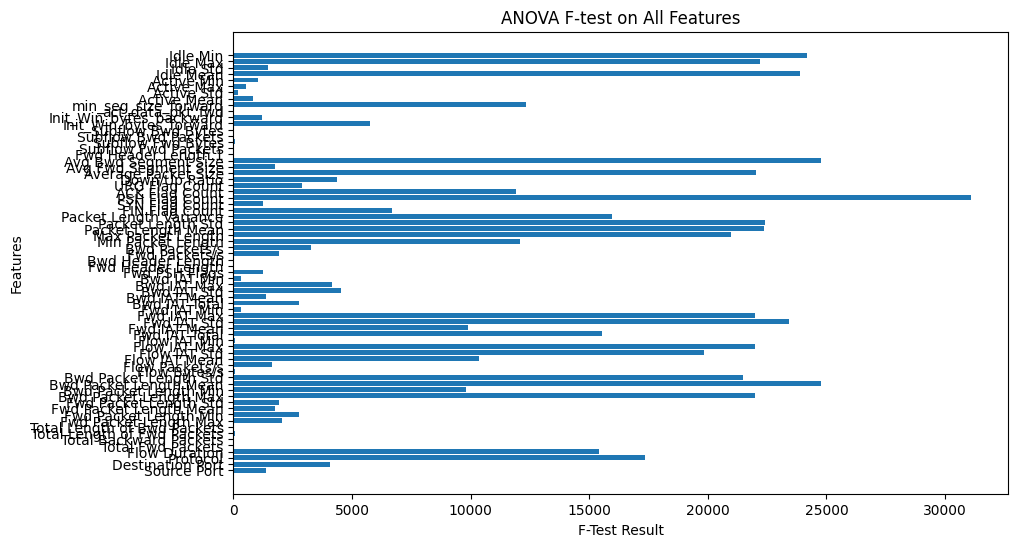

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming fs.scores_ and feature names are available
# Create a bar plot of the ANOVA F-test scores
plt.figure(figsize=(10, 6))  # Set figure size for better clarity
plt.barh(range(len(fs.scores_)), fs.scores_, align='center')  # Horizontal bar chart for better readability

# Adding feature names on the y-axis if available
plt.yticks(range(len(fs.scores_)), X_train.columns)  # Use the actual feature names if needed

plt.title("ANOVA F-test on All Features")
plt.xlabel("F-Test Result")
plt.ylabel("Features")
plt.savefig('Desktop/nid/AllFeatures.png')  # Save as a PNG file for better compatibility
plt.show()


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

def selectKBest(train, test, valid, k):
    sel = SelectKBest(score_func=f_classif, k=k)

    # Prepare the data
    y_train = train["Label"]
    X_train = train.drop("Label", axis=1)

    # Perform ANOVA F-test
    sel.fit(X_train, y_train)

    # Transform datasets
    X_test_transformed = sel.transform(test.drop("Label", axis=1))
    X_valid_transformed = sel.transform(valid.drop("Label", axis=1))

    # Get the selected features
    mask = sel.get_support()
    selected_features = X_train.columns[mask].tolist()

    return selected_features, X_test_transformed, X_valid_transformed

# Now, select the 15 best features and transform the datasets
selected_features, X_test_transformed, X_valid_transformed = selectKBest(df_train, df_test, df_validation, 15)

# Print the selected features
print("Selected 15 Best Features:")
print(selected_features)

# Prepare datasets for training and evaluation
y_train_selected = df_train["Label"]
x_train_selected = df_train[selected_features]  # Using selected features

# Prepare test and validation datasets
y_test_selected = df_test["Label"]
x_test_selected = X_test_transformed  # Already transformed
y_valid_selected = df_validation["Label"]
x_valid_selected = X_valid_transformed  # Already transformed

# Check shapes of the new datasets (optional)
print(f"x_train_selected shape: {x_train_selected.shape}")
print(f"y_train_selected shape: {y_train_selected.shape}")
print(f"x_test_selected shape: {x_test_selected.shape}")
print(f"y_test_selected shape: {y_test_selected.shape}")
print(f"x_valid_selected shape: {x_valid_selected.shape}")
print(f"y_valid_selected shape: {y_valid_selected.shape}")


Selected 15 Best Features:
['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Std', 'Fwd IAT Max', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'PSH Flag Count', 'Average Packet Size', 'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min']
x_train_selected shape: (95883, 15)
y_train_selected shape: (95883,)
x_test_selected shape: (29964, 15)
y_test_selected shape: (29964,)
x_valid_selected shape: (23971, 15)
y_valid_selected shape: (23971,)


In [ ]:
# Assuming you've already defined the necessary imports and the selectKBest function above

# Select the 15 best features
selected_features, X_test_transformed, X_valid_transformed = selectKBest(df_train, df_test, df_validation, 15)

# Print the selected features
print("Selected 15 Best Features:")
print(selected_features)

# After selecting the features, you can prepare your datasets for training and evaluation
# Prepare datasets for training and evaluation
y_train_selected = df_train["Label"]
x_train_selected = df_train[selected_features]  # Using selected features

# Prepare test and validation datasets
y_test_selected = df_test["Label"]
x_test_selected = X_test_transformed  # Already transformed
y_valid_selected = df_validation["Label"]
x_valid_selected = X_valid_transformed  # Already transformed

# Check shapes of the new datasets (optional)
print(f"x_train_selected shape: {x_train_selected.shape}")
print(f"y_train_selected shape: {y_train_selected.shape}")
print(f"x_test_selected shape: {x_test_selected.shape}")
print(f"y_test_selected shape: {y_test_selected.shape}")
print(f"x_valid_selected shape: {x_valid_selected.shape}")
print(f"y_valid_selected shape: {y_valid_selected.shape}")


Selected 15 Best Features:
['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Std', 'Fwd IAT Max', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'PSH Flag Count', 'Average Packet Size', 'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min']
x_train_selected shape: (95883, 15)
y_train_selected shape: (95883,)
x_test_selected shape: (29964, 15)
y_test_selected shape: (29964,)
x_valid_selected shape: (23971, 15)
y_valid_selected shape: (23971,)


In [ ]:
# Select the 15 best features
selected_features, X_test_transformed, X_valid_transformed = selectKBest(df_train, df_test, df_validation, 15)

# Print the selected features
print("Selected 15 Best Features:")
print(selected_features)

# Extracting labels from the training and test datasets
y_train_selected = df_train["Label"]
y_test_selected = df_test["Label"]

# Creating new datasets with only the selected features
x_train_selected = new_dataset(df_train, selected_features)  # Using selected features
x_test_selected = new_dataset(df_test, selected_features)     # Using selected features

# Check shapes of the new datasets (optional)
print(f"x_train_selected shape: {x_train_selected.shape}")
print(f"y_train_selected shape: {y_train_selected.shape}")
print(f"x_test_selected shape: {x_test_selected.shape}")
print(f"y_test_selected shape: {y_test_selected.shape}")


Selected 15 Best Features:
['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Std', 'Fwd IAT Max', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'PSH Flag Count', 'Average Packet Size', 'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min']
x_train_selected shape: (95883, 15)
y_train_selected shape: (95883,)
x_test_selected shape: (29964, 15)
y_test_selected shape: (29964,)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Assuming you have already defined x_train_selected, y_train_selected, x_test_selected, y_test_selected

# Training the DecisionTreeClassifier and evaluating its accuracy
tree = DecisionTreeClassifier()
tree.fit(x_train_selected, y_train_selected)  # Use selected training data

# Make predictions on the test set
y_test_pred_selected = tree.predict(x_test_selected)  # Use selected test data

# Evaluate predictions
accuracy = accuracy_score(y_test_selected, y_test_pred_selected)
print('Accuracy: %.5f' % (accuracy * 100))


Accuracy: 97.40355


In [ ]:
import pickle

# Define the path where you want to save the selected features
file_path = "Desktop/nid/selected_features.txt"

# Open the file in write mode and save the selected features
with open(file_path, "w") as f:
    for feature in selected_features:  # Use selected_features
        f.write(feature + "\n")


In [ ]:
# Define the path to the file containing the selected features
file_path = "Desktop/nid/selected_features.txt"

# Read the file and print the features
with open(file_path, "r") as f:
    saved_features = f.readlines()

# Clean up the list (remove newline characters)
saved_features = [feature.strip() for feature in saved_features]

# Print the saved features
print("Saved Selected Features:")
for feature in saved_features:
    print(feature)

# Check if the number of features is correct
print(f"\nTotal features saved: {len(saved_features)}")


Saved Selected Features:
Bwd Packet Length Max
Bwd Packet Length Mean
Bwd Packet Length Std
Flow IAT Max
Fwd IAT Std
Fwd IAT Max
Max Packet Length
Packet Length Mean
Packet Length Std
PSH Flag Count
Average Packet Size
Avg Bwd Segment Size
Idle Mean
Idle Max
Idle Min

Total features saved: 15


In [ ]:
# Define the path to the file containing the selected features
file_path = "Desktop/nid/selected_features.txt"

# Read the file and print the features
with open(file_path, "r") as f:
    saved_features = f.readlines()

# Clean up the list (remove newline characters)
saved_features = [feature.strip() for feature in saved_features]

# Print the saved features
print("Saved Selected Features:")
for feature in saved_features:
    print(feature)

# Check if the number of features is correct
print(f"\nTotal features saved: {len(saved_features)}")


Saved Selected Features:
Bwd Packet Length Max
Bwd Packet Length Mean
Bwd Packet Length Std
Flow IAT Max
Fwd IAT Std
Fwd IAT Max
Max Packet Length
Packet Length Mean
Packet Length Std
PSH Flag Count
Average Packet Size
Avg Bwd Segment Size
Idle Mean
Idle Max
Idle Min

Total features saved: 15


In [ ]:
# Method used to ensure that the name in the feature file
# matches the ones in the dataframes, ensuring feature reduction is performed

def correct_names(columns, orig):
    col = []
    for orig_feature in orig:
        for df_column in columns:
            # Stripping any spaces or extra characters to match features correctly
            if df_column.strip() == orig_feature.strip():
                col.append(df_column)

    return col


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Function to reduce memory usage (ensure this function is implemented)
def reduce_memory_usage(df, convert_to_category=True):
    # Placeholder for memory reduction logic
    return df

# Load and optimize the train, test, and validation datasets without specifying an index
df_train_vanilla = pd.read_csv(r"Desktop/nid/train_data.csv")
df_train_vanilla = reduce_memory_usage(df_train_vanilla, convert_to_category=False)

df_test_vanilla = pd.read_csv(r"Desktop/nid/test_data.csv")
df_test_vanilla = reduce_memory_usage(df_test_vanilla, convert_to_category=False)

df_validation_vanilla = pd.read_csv(r"Desktop/nid/validation_data.csv")
df_validation_vanilla = reduce_memory_usage(df_validation_vanilla, convert_to_category=False)

# Load the encoder
encoder = LabelEncoder()
encoder.classes_ = np.load(r'Desktop/nid/classes.npy', allow_pickle=True)

# Optional: Print the shapes of the DataFrames to confirm successful loading
print("Train DataFrame shape:", df_train_vanilla.shape)
print("Test DataFrame shape:", df_test_vanilla.shape)
print("Validation DataFrame shape:", df_validation_vanilla.shape)


Train DataFrame shape: (95883, 69)
Test DataFrame shape: (29964, 69)
Validation DataFrame shape: (23971, 16)


In [ ]:
# Transforming the 'Label' column in the training dataset using the LabelEncoder
df_train_vanilla["Label"] = encoder.transform(df_train_vanilla["Label"])

# Optional: Print a few entries to confirm the transformation
print(df_train_vanilla["Label"].head())


0    3
1    3
2    1
3    2
4    2
Name: Label, dtype: int64


array([[<Axes: title={'center': 'Label'}>]], dtype=object)

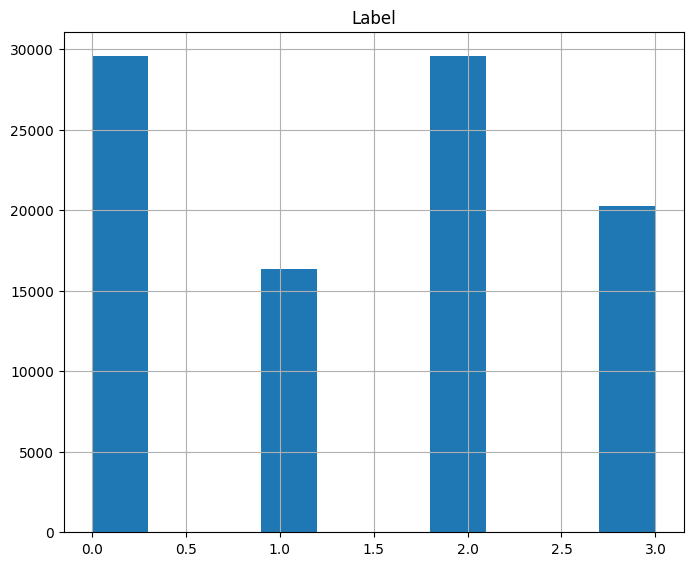

In [ ]:
# It should be noted that the histogram is created in order to see how many
# instances of each attack occur and help guide the sampling strategy

df_train_vanilla.hist(column="Label")

In [ ]:
# The values per attack

print(df_train_vanilla["Label"].value_counts())

Label
0    29606
2    29605
3    20296
1    16376
Name: count, dtype: int64


In [ ]:
# Correcting the names of the features to be used for the dataset reduction
features = correct_names(df_validation_vanilla.columns, saved_features)

# Optional: Print the resulting features list to confirm the mapping
print("Corrected Feature Names:")
print(features)


Corrected Feature Names:
['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Std', 'Fwd IAT Max', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'PSH Flag Count', 'Average Packet Size', 'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Function to reduce memory usage (ensure this function is implemented)
def reduce_memory_usage(df, convert_to_category=True):
    # Placeholder for memory reduction logic
    return df

# Load and optimize the train, test, and validation datasets without specifying an index
df_train_vanilla = pd.read_csv(r"Desktop/nid/train_data.csv")
df_train_vanilla = reduce_memory_usage(df_train_vanilla, convert_to_category=False)

df_test_vanilla = pd.read_csv(r"Desktop/nid/test_data.csv")
df_test_vanilla = reduce_memory_usage(df_test_vanilla, convert_to_category=False)

df_validation_vanilla = pd.read_csv(r"Desktop/nid/validation_data.csv")
df_validation_vanilla = reduce_memory_usage(df_validation_vanilla, convert_to_category=False)

# Load the encoder
encoder = LabelEncoder()
encoder.classes_ = np.load(r'Desktop/nid/classes.npy', allow_pickle=True)

# Optional: Print the shapes of the DataFrames to confirm successful loading
print("Train DataFrame shape:", df_train_vanilla.shape)
print("Test DataFrame shape:", df_test_vanilla.shape)
print("Validation DataFrame shape:", df_validation_vanilla.shape)

# Transforming the 'Label' column in the training dataset using the LabelEncoder
df_train_vanilla["Label"] = encoder.transform(df_train_vanilla["Label"])

# Optional: Print a few entries to confirm the transformation
print(df_train_vanilla["Label"].head())

# Perform feature reduction for the training dataset
# Extract the labels for the training set
y_train = df_train_vanilla["Label"]

# Use the 'new_dataset' function to keep only the selected features
x_train = new_dataset(df_train_vanilla, features)  # 'features' should be defined

# Print the shapes of the new datasets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Prepare the columns for the new Pandas DataFrame that will save the reduced features data
train_columns = x_train.columns.to_list()
train_columns.append('Label')

# Combine the features and labels into a new DataFrame for the training dataset
df_train = pd.DataFrame(np.c_[x_train, y_train], columns=train_columns)

# Optionally reduce memory usage (if needed)
df_train = reduce_memory_usage(df_train, convert_to_category=False)

# Save the training DataFrame to a CSV file
df_train.to_csv("Desktop/nid/train_data_reduced.csv", index=False)  # Save reduced train dataset

# Perform feature reduction for the test dataset
# Extract the labels for the test set
y_test = df_test_vanilla["Label"]

# Use the 'new_dataset' function to keep only the selected features
x_test = new_dataset(df_test_vanilla, features)  # Use the same 'features'

# Print the shapes of the new test datasets
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Encoding the test dataset labels
y_test = encoder.transform(y_test)

# Prepare the columns for the new Pandas DataFrame that will save the reduced features data
test_columns = x_test.columns.to_list()
test_columns.append('Label')

# Combine the features and labels into a new DataFrame for the test dataset
df_test = pd.DataFrame(np.c_[x_test, y_test], columns=test_columns)

# Optionally reduce memory usage (if needed)
df_test = reduce_memory_usage(df_test, convert_to_category=False)

# Save the test DataFrame to a CSV file
df_test.to_csv("Desktop/nid/test_data_reduced.csv", index=False)  # Save reduced test dataset

# Perform feature reduction for the validation dataset
# Extract the labels for the validation set
y_valid = df_validation_vanilla["Label"]

# Use the 'new_dataset' function to keep only the selected features
x_valid = new_dataset(df_validation_vanilla, features)  # 'features' should be defined

# Print the shapes of the new validation datasets
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

# Encoding the validation dataset labels
y_valid = encoder.transform(y_valid)

# Prepare the columns for the new Pandas DataFrame that will save the reduced features data
valid_columns = x_valid.columns.to_list()
valid_columns.append('Label')

# Combine the features and labels into a new DataFrame for the validation dataset
df_validation = pd.DataFrame(np.c_[x_valid, y_valid], columns=valid_columns)

# Optionally reduce memory usage (if needed)
df_validation = reduce_memory_usage(df_validation, convert_to_category=False)

# Save the validation DataFrame to a CSV file
df_validation.to_csv("Desktop/nid/validation_data_reduced.csv", index=False)  # Save reduced validation dataset


Train DataFrame shape: (95883, 69)
Test DataFrame shape: (29964, 69)
Validation DataFrame shape: (23971, 16)
0    3
1    3
2    1
3    2
4    2
Name: Label, dtype: int64
x_train shape: (95883, 15)
y_train shape: (95883,)
x_test shape: (29964, 15)
y_test shape: (29964,)
x_valid shape: (23971, 15)
y_valid shape: (23971,)


In [ ]:
# Print shapes
print("Shapes of datasets:")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

# Print sample values from each dataset
print("\nSample values from the datasets:")
print("x_train (first 5 samples):\n", x_train[:5])
print("y_train (first 5 labels):\n", y_train[:5])

print("\nx_test (first 5 samples):\n", x_test[:5])
print("y_test (first 5 labels):\n", y_test[:5])

print("\nx_valid (first 5 samples):\n", x_valid[:5])
print("y_valid (first 5 labels):\n", y_valid[:5])


Shapes of datasets:
x_train shape: (95883, 15)
y_train shape: (95883,)
x_test shape: (29964, 15)
y_test shape: (29964,)
x_valid shape: (23971, 15)
y_valid shape: (23971,)

Sample values from the datasets:
x_train (first 5 samples):
    Bwd Packet Length Max  Bwd Packet Length Mean  Bwd Packet Length Std  \
0                    6.0                     6.0                    0.0   
1                    6.0                     6.0                    0.0   
2                11592.0                  2902.0                 5796.0   
3                10144.0                  2320.0                 4420.0   
4                    0.0                     0.0                    0.0   

   Flow IAT Max  Fwd IAT Std  Fwd IAT Max  Max Packet Length  \
0          90.0          0.0          0.0                6.0   
1          54.0          0.0          0.0                6.0   
2    74000000.0   25900000.0   74000000.0            11592.0   
3    98800000.0   44200000.0   98800000.0            10144.0

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import Normalizer, PowerTransformer
import joblib
import tensorflow as tf

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='softmax'))  # Assuming you have 16 classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Prepare the data
normalizer = Normalizer()
standardizer = PowerTransformer(method='yeo-johnson')

# Assuming x_train, x_test, and x_valid are already defined from your previous steps
# Normalize and standardize the training dataset
X_train = normalizer.fit_transform(x_train)  # Your training features
X_train = standardizer.fit_transform(X_train)

# Normalize and standardize the test dataset
X_test = normalizer.transform(x_test)  # Use x_test
X_test = standardizer.transform(X_test)

# Normalize and standardize the validation dataset
X_valid = normalizer.transform(x_valid)  # Use x_valid
X_valid = standardizer.transform(X_valid)

# Reshape data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Shape: (samples, time steps, features)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Shape: (samples, time steps, features)
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))  # Shape: (samples, time steps, features)

# Save the Normalizer and Transformer for future use
normalizer_filename = "Desktop/nid/normalizer.save"
joblib.dump(normalizer, normalizer_filename)

standardizer_filename = "Desktop/nid/standardizer.save"
joblib.dump(standardizer, standardizer_filename)

# Callbacks for training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=5,
                        verbose=1,
                        restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                patience=3,
                                verbose=1,
                                factor=0.2,
                                min_lr=1e-6)

# Create and train the LSTM model
model_lstm = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model_lstm.summary()

# Fit the model
model_lstm.fit(X_train, y_train,  # Use y_train for labels (from training dataset)
                epochs=25,
                batch_size=32,
                verbose=1,
                validation_data=(X_valid, y_valid),  # Use validation set for validation data
                callbacks=[early_stop, reduce_lr])


C:\Users\test2\anaconda3\envs\IDS\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 128)              │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,744 (491.19 KB)

 Trainable params: 125,744 (491.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2997/2997 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.7388 - loss: 0.7238 - val_accuracy: 0.8285 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 2/25
2997/2997 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8360 - loss: 0.4236 - val_accuracy: 0.8486 - val_loss: 0.3831 - learning_rate: 0.0010
Epoch 3/25
2997/2997 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8494 - loss: 0.3888 - val_accuracy: 0.8568 - val_loss: 0.3675 - learning_rate: 0.0010
Epoch 4/25
2997/2997 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8571 - loss: 0.3712 - val_accuracy: 0.8673 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 5/25
2997/2997 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8606 - loss: 0.3558 - val_accuracy: 0.8696 - val_loss: 0.3272 - learning_rate: 0.0010
Epoch 6/25
2997/2997 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8629 - loss: 0.3469 - val_accuracy: 0.8650 - val_loss: 0.3285 - learning_rate: 0.0010
Epoch 7/25
2997/2997 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8

In [ ]:
# Save the model


model_lstm.save('Desktop/nid/keras_ids_model_lstm.h5')
print("Model saved as 'keras_ids_model_lstm.h5'")


Model saved as 'keras_ids_model_lstm.h5'


Model loaded successfully.
937/937 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


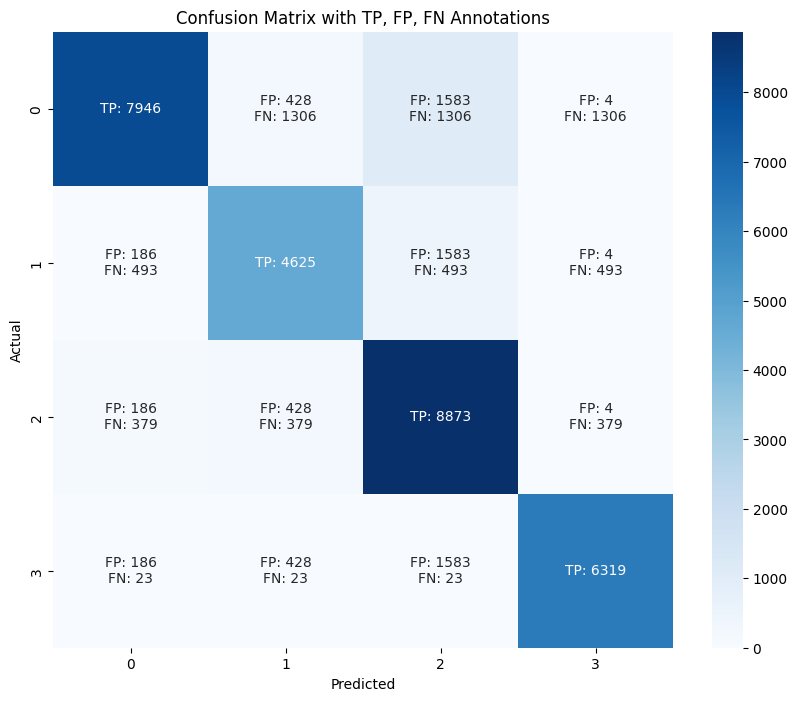

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      9252
           1       0.92      0.90      0.91      5118
           2       0.85      0.96      0.90      9252
           3       1.00      1.00      1.00      6342

    accuracy                           0.93     29964
   macro avg       0.94      0.93      0.93     29964
weighted avg       0.93      0.93      0.93     29964



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# Load the model
model_lstm = load_model('Desktop/nid/keras_ids_model_lstm.h5')
print("Model loaded successfully.")

# Make predictions on the test dataset
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels

# Get the unique classes
classes = np.unique(y_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Calculate TP, TN, FP, FN
TP = np.diag(cm)  # True Positives
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (FP + FN + TP)  # True Negatives

# Create a new annotated confusion matrix
annot = []
for i in range(len(classes)):
    row = []
    for j in range(len(classes)):
        if i == j:
            row.append(f'TP: {TP[i]}')  # True Positives
        else:
            row.append(f'FP: {FP[j]}\nFN: {FN[i]}')  # False Positives and False Negatives
    annot.append(row)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=True,
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with TP, FP, FN Annotations')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


In [ ]:
import pandas as pd
import random

# Load the reduced test dataset
df_test = pd.read_csv("Desktop/nid/test_data_reduced.csv")

# Filter records with label 2
filtered_records = df_test[df_test['Label'] == 2]

# Check if there are any records with label 2
if not filtered_records.empty:
    # Select a random record from the filtered records
    random_index = random.randint(0, filtered_records.shape[0] - 1)
    random_record = filtered_records.iloc[random_index]

    # Print the random record details
    print("Random Record Index:", random_index)
    print("Random Record Details:\n", random_record)
else:
    print("No records found with label 2.")


Random Record Index: 8981
Random Record Details:
 Bwd Packet Length Max         4344.0
Bwd Packet Length Mean        1656.0
Bwd Packet Length Std         1761.0
Flow IAT Max              98800000.0
Fwd IAT Std               44200000.0
Fwd IAT Max               98800000.0
Max Packet Length             4344.0
Packet Length Mean             852.5
Packet Length Std             1460.0
PSH Flag Count                   0.0
Average Packet Size            918.0
Avg Bwd Segment Size          1656.0
Idle Mean                 98800000.0
Idle Max                  98800000.0
Idle Min                  98800000.0
Label                            2.0
Name: 29114, dtype: float64


In [ ]:
import numpy as np
import joblib
from keras.models import load_model

# Load the saved normalizer, standardizer, and model
normalizer = joblib.load("Desktop/nid/normalizer.save")
standardizer = joblib.load("Desktop/nid/standardizer.save")
model_lstm = load_model('Desktop/nid/keras_ids_model_lstm.h5')

# Manually input your feature values based on the random record you retrieved
custom_input = np.array([
    4344.0,  # Bwd Packet Length Max
    1656.0,  # Bwd Packet Length Mean
    1761.0,  # Bwd Packet Length Std
    98800000.0, # Flow IAT Max
    44200000.0, # Fwd IAT Std
    98800000.0, # Fwd IAT Max
    4344.0,  # Max Packet Length
    852.5,   # Packet Length Mean
    1460.0,  # Packet Length Std
    0.0,     # PSH Flag Count
    918.0,   # Average Packet Size
    1656.0,  # Avg Bwd Segment Size
    98800000.0, # Idle Mean
    98800000.0, # Idle Max
    98800000.0  # Idle Min
])

# Normalize and standardize the custom input
custom_input = normalizer.transform(custom_input.reshape(1, -1))  # Reshape for normalization
custom_input = standardizer.transform(custom_input)  # Standardize

# Reshape the input for the LSTM model [samples, time steps, features]
custom_input = custom_input.reshape((custom_input.shape[0], 1, custom_input.shape[1]))

# Make the prediction using the model
predicted_class = model_lstm.predict(custom_input)
predicted_class_label = np.argmax(predicted_class, axis=1)

# Print the predicted class
print("Predicted Class for Custom Input:", predicted_class_label[0])


C:\Users\test2\anaconda3\envs\IDS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicted Class for Custom Input: 2
